# Lab 11: Transformers

In today's lab, we will learn how to create a transformer from scratch, then
we'll take a look at ViT (the visual transformer). Some of the material in this
lab comes from the following online sources:

- https://medium.com/the-dl/transformers-from-scratch-in-pytorch-8777e346ca51
- https://towardsdatascience.com/how-to-code-the-transformer-in-pytorch-24db27c8f9ec
- https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632
- https://github.com/lucidrains/vit-pytorch#vision-transformer---pytorch
- https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c

<img src="img/optimus_prime.jpg" title="Transformer" style="width: 600px;" />

The above photo needs a credit!

## Transformers and machine learning trends

Before the arrival of transformers, CNNs were most often used in the visual domain, while RNNs like LSTMs were most often used in NLP.
There were many attempts at crossover, without much real success. Neither approach seemed capable of dealing with very large complex
natural language datasets effectively.

In 2017, the Transformer was introduced. "Attention is all you need" has been cited more than 38,000 times.

The main concept in a Transformer is self-attention, which replaces the sequential processing of RNNs and the local
processing of CNNs with the ability to adaptively extract arbitrary relationships between different elements of its input,
output, and memory state.

## Transformer architecture

We will use [Frank Odom's implementation of the Transformer in PyTorch](https://github.com/fkodom/transformer-from-scratch/tree/main/src).

The architecture of the transformer looks like this:

<img src="img/Transformer.png" title="Transformer" style="width: 600px;" />

Here is a summary of the Transformer's details and mathematics:

<img src="img/SummaryTransformer.PNG" title="Transformer Details" style="width: 1000px;" />

There are several processes that we need to implement in the model. We go one by one.

## Attention

Before Transformers, the standard model for sequence-to-sequence learning was seq2seq, which combines an RNN for encoding with
an RNN for decoding. The encoder processes the input and retains important information in a sequence or block of memory,
while the decoder extracts the important information from the memory in order to produce an output.

One problem with seq2seq is that some information may be lost while processing a long sequence.
Attention allows us to focus on specific inputs directly.

An attention-based decoder, when we want to produce the output token at a target position, will calculate an attention score
with the encoder's memory at each input position. A high score for a particular encoder position indicates that it is more important
than another position. We essentially use the decoder's input to select which encoder output(s) should be used to calculate the
current decoder output. Given decoder input $q$ (the *query*) and encoder outputs $p_i$, the attention operation calculates dot
products between $q$ and each $p_i$. The dot products give the similarity of each pair. The dot products are softmaxed to get
positive weights summing to 1, and the weighted average $r$ is calculated as

$$r = \sum_i \frac{e^{p_i\cdot q}}{\sum_j e^{p_j\cdot q}}p_i .$$

We can think of $r$ as an adaptively selected combination of the inputs most relevant to producing an output.

### Multi-head self attention

Transformers use a specific type of attention mechanism, referred to as multi-head self attention.
This is the most important part of the model. An illustration from the paper is shown below.

<img src="img/MultiHeadAttention.png" title="Transformer" style="width: 600px;" />

The multi-head attention layer is described as:

$$\text{Attention}(Q,K,V)=\text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$$

$Q$, $K$, and $V$ are batches of matrices, each with shape <code>(batch_size, seq_length, num_features)</code>.
When we are talking about *self* attention, each of the three matrices in
each batch is just a separate linear projection of the same input $\bar{h}_t^{l-1}$.

Multiplying the query $Q$ with the key $K$ arrays results in a <code>(batch_size, seq_length, seq_length)</code> array,
which tells us roughly how important each element in the sequence is to each other element in the sequence. These dot
products are converted to normalized weights using a softmax across rows, so that each row of weights sums to one.
Finally, the weight matrix attention is applied to the value ($V$) array using matrix multiplication. We thus get,
for each token in the input sequence, a weighted average of the rows of $V$, each of which corresponds to one of the
elements in the input sequence.

Here is code for the scaled dot-product operation that is part of a multi-head attention layer:

In [1]:
import torch
import torch.nn.functional as f
from torch import Tensor, nn

def scaled_dot_product_attention(query: Tensor, key: Tensor, value: Tensor) -> Tensor:
    # MatMul operations are translated to torch.bmm in PyTorch
    temp = query.bmm(key.transpose(1, 2))
    scale = query.size(-1) ** 0.5
    softmax = f.softmax(temp / scale, dim=-1)
    return softmax.bmm(value)

A multi-head attention module is composed of several identical
*attention head* modules.
Each attention head contains three linear transformations for $Q$, $K$, and $V$ and combines them using scaled dot-product attention.
Note that this attention head could be used for self attention or another type of attention such as decoder-to-encoder attention, since
we keep $Q$, $K$, and $V$ separate.

In [3]:
class AttentionHead(nn.Module):
    def __init__(self, dim_in: int, dim_q: int, dim_k: int):
        super().__init__()
        self.q = nn.Linear(dim_in, dim_q)
        self.k = nn.Linear(dim_in, dim_k)
        self.v = nn.Linear(dim_in, dim_k)

    def forward(self, query: Tensor, key: Tensor, value: Tensor) -> Tensor:
        return scaled_dot_product_attention(self.q(query), self.k(key), self.v(value))

Multiple attention heads can be combined with the output concatenation and linear transformation to construct a multi-head attention layer:

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads: int, dim_in: int, dim_q: int, dim_k: int):
        super().__init__()
        self.heads = nn.ModuleList(
            [AttentionHead(dim_in, dim_q, dim_k) for _ in range(num_heads)]
        )
        self.linear = nn.Linear(num_heads * dim_k, dim_in)

    def forward(self, query: Tensor, key: Tensor, value: Tensor) -> Tensor:
        return self.linear(
            torch.cat([h(query, key, value) for h in self.heads], dim=-1)
        )

Each attention head computes its own transformation of the query, key, and value arrays,
and then applies scaled dot-product attention. Conceptually, this means each head can attend to a different part of the input sequence, independent of the others. Increasing the number of attention heads allows the model to pay attention to more parts of the sequence at
once, which makes the model more powerful.

### Positional Encoding

To complete the transformer encoder, we need another component, the *position encoder*.
The <code>MultiHeadAttention</code> class we just write has no trainable components that depend on a token's position
in the sequence (axis 1 of the input tensor). Meaning all of the weight matrices we have seen so far
*perform the same calculation for every input position*; that is, we don't have any position-dependent weights.
All of the operations so far operate over the *feature dimension* (axis 2). This is good in that the model is compatible with any sequence
length. But without *any* information about position, our model is going to be unable to differentiate between different orderings of
the input -- we'll get the same result regardless of the order of the tokens in the input.

Since order matters ("Ridgemont was in the store" has a different
meaning from "The store was in Ridgemont"), we need some way to provide the model with information about tokens' positions in the input sequence.
Whatever strategy we use should provide information about the relative position of data points in the input sequences.
In the Transformer, positional information is encoded using trigonometric functions in a constant 2D matrix $PE$:

$$PE_{(pos,2i)}=\sin (\frac{pos}{10000^{2i/d_{model}}})$$
$$PE_{(pos,2i+1)}=\cos (\frac{pos}{10000^{2i/d_{model}}}),$$

where $pos$ refers to a position in the input sentence sequence and $i$ refers to the position along the embedding vector dimension.
This matrix is *added* to the matrix consisting of the embeddings of each of the input tokens:

<img src="img/positionalencoder.png" title="Positional Encoder" style="width: 400px;" />

Position encoding can implemented as follows (put this in `utils.py`):

In [6]:
def position_encoding(seq_len: int, dim_model: int, device: torch.device = torch.device("cpu")) -> Tensor:
    pos = torch.arange(seq_len, dtype=torch.float, device=device).reshape(1, -1, 1)
    dim = torch.arange(dim_model, dtype=torch.float, device=device).reshape(1, 1, -1)
    phase = pos / (1e4 ** (dim // dim_model))

    return torch.where(dim.long() % 2 == 0, torch.sin(phase), torch.cos(phase))

These sinusoidal encodings allow us to work with arbirary length sequences because the sine and cosine functions are periodic in the range
$[-1, 1]$. One hope is that if during inference we are provided with an input sequence longer than any found during training.
The position encodings of the last elements in the sequence would be different from anything the model has seen before, but with the
periodic sine/cosine encoding, there will still be some similar structure, with the new encodings being very similar to neighboring encodings the model has seen before. For this reason, despite the fact that learned embeddings appeared to perform equally as well, the authors chose
this fixed sinusoidal encoding.

### The complete encoder

The transformer uses an encoder-decoder architecture. The encoder processes the input sequence and returns a sequence of
feature vectors or memory vectors, while the decoder outputs a prediction of the target sequence,
incorporating information from the encoder memory.

First, let's complete the transformer layer with the two-layer feed forward network. Put this in `utils.py`:

In [7]:
def feed_forward(dim_input: int = 512, dim_feedforward: int = 2048) -> nn.Module:
    return nn.Sequential(
        nn.Linear(dim_input, dim_feedforward),
        nn.ReLU(),
        nn.Linear(dim_feedforward, dim_input),
    )

Let's create a residual module to encapsulate the feed forward network or attention
model along with the common dropout and LayerNorm operations (also in `utils.py`):

In [8]:
class Residual(nn.Module):
    def __init__(self, sublayer: nn.Module, dimension: int, dropout: float = 0.1):
        super().__init__()
        self.sublayer = sublayer
        self.norm = nn.LayerNorm(dimension)
        self.dropout = nn.Dropout(dropout)

    def forward(self, *tensors: Tensor) -> Tensor:
        # Assume that the "query" tensor is given first, so we can compute the
        # residual.  This matches the signature of 'MultiHeadAttention'.
        return self.norm(tensors[0] + self.dropout(self.sublayer(*tensors)))

Now we can create the complete encoder! Put this in `encoder.py`. First, the encoder layer
module, which comprised a self attention residual block followed by a fully connected residual block:

In [10]:
class TransformerEncoderLayer(nn.Module):
    def __init__(
        self,
        dim_model: int = 512,
        num_heads: int = 6,
        dim_feedforward: int = 2048,
        dropout: float = 0.1,
    ):
        super().__init__()
        dim_q = dim_k = max(dim_model // num_heads, 1)
        self.attention = Residual(
            MultiHeadAttention(num_heads, dim_model, dim_q, dim_k),
            dimension=dim_model,
            dropout=dropout,
        )
        self.feed_forward = Residual(
            feed_forward(dim_model, dim_feedforward),
            dimension=dim_model,
            dropout=dropout,
        )

    def forward(self, src: Tensor) -> Tensor:
        src = self.attention(src, src, src)
        return self.feed_forward(src)

Then the Transformer encoder just encapsulates several transformer encoder layers:

In [11]:
class TransformerEncoder(nn.Module):
    def __init__(
        self,
        num_layers: int = 6,
        dim_model: int = 512,
        num_heads: int = 8,
        dim_feedforward: int = 2048,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.layers = nn.ModuleList(
            [
                TransformerEncoderLayer(dim_model, num_heads, dim_feedforward, dropout)
                for _ in range(num_layers)
            ]
        )

    def forward(self, src: Tensor) -> Tensor:
        seq_len, dimension = src.size(1), src.size(2)
        src += position_encoding(seq_len, dimension)
        for layer in self.layers:
            src = layer(src)

        return src

### The decoder

The decoder module is quite similar to the encoder, with just a few small differences:
- The decoder accepts two inputs (the target sequence and the encoder memory), rather than one input.
- There are two multi-head attention modules per layer (the target sequence self-attention module and the decoder-encoder attention module) rather than just one.
- The second multi-head attention module, rather than strict self attention, expects the encoder memory as $K$ and $V$.
- Since accessing future elements of the target sequence would be "cheating," we need to mask out future elements of the input target sequence.

First, we have the decoder version of the transformer layer and the decoder module itself:

In [12]:
class TransformerDecoderLayer(nn.Module):
    def __init__(
        self,
        dim_model: int = 512,
        num_heads: int = 6,
        dim_feedforward: int = 2048,
        dropout: float = 0.1,
    ):
        super().__init__()
        dim_q = dim_k = max(dim_model // num_heads, 1)
        self.attention_1 = Residual(
            MultiHeadAttention(num_heads, dim_model, dim_q, dim_k),
            dimension=dim_model,
            dropout=dropout,
        )
        self.attention_2 = Residual(
            MultiHeadAttention(num_heads, dim_model, dim_q, dim_k),
            dimension=dim_model,
            dropout=dropout,
        )
        self.feed_forward = Residual(
            feed_forward(dim_model, dim_feedforward),
            dimension=dim_model,
            dropout=dropout,
        )

    def forward(self, tgt: Tensor, memory: Tensor) -> Tensor:
        tgt = self.attention_1(tgt, tgt, tgt)
        tgt = self.attention_2(tgt, memory, memory)
        return self.feed_forward(tgt)

    
class TransformerDecoder(nn.Module):
    def __init__(
        self,
        num_layers: int = 6,
        dim_model: int = 512,
        num_heads: int = 8,
        dim_feedforward: int = 2048,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.layers = nn.ModuleList(
            [
                TransformerDecoderLayer(dim_model, num_heads, dim_feedforward, dropout)
                for _ in range(num_layers)
            ]
        )
        self.linear = nn.Linear(dim_model, dim_model)

    def forward(self, tgt: Tensor, memory: Tensor) -> Tensor:
        seq_len, dimension = tgt.size(1), tgt.size(2)
        tgt += position_encoding(seq_len, dimension)
        for layer in self.layers:
            tgt = layer(tgt, memory)

        return torch.softmax(self.linear(tgt), dim=-1)


Note that there is not, as of yet, any masked attention implementation here!
Making this version of the Transformer work in practice would require at least that.

### Putting it together

Now we can put the encoder and decoder together:

In [13]:
class Transformer(nn.Module):
    def __init__(
        self, 
        num_encoder_layers: int = 6,
        num_decoder_layers: int = 6,
        dim_model: int = 512, 
        num_heads: int = 6, 
        dim_feedforward: int = 2048, 
        dropout: float = 0.1, 
        activation: nn.Module = nn.ReLU(),
    ):
        super().__init__()
        self.encoder = TransformerEncoder(
            num_layers=num_encoder_layers,
            dim_model=dim_model,
            num_heads=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.decoder = TransformerDecoder(
            num_layers=num_decoder_layers,
            dim_model=dim_model,
            num_heads=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )

    def forward(self, src: Tensor, tgt: Tensor) -> Tensor:
        return self.decoder(tgt, self.encoder(src))

Let’s create a simple test, as a sanity check for our implementation. We can construct random tensors for the input and target sequences, check that our model executes without errors, and confirm that the output tensor has the correct shape:

In [14]:
src = torch.rand(64, 32, 512)
tgt = torch.rand(64, 16, 512)
out = Transformer()(src, tgt)
print(out.shape)
# torch.Size([64, 16, 512])

torch.Size([64, 16, 512])


You could try implementing masked attention and training this Transformer model on a
sequence-to-sequence problem. However, to understand masking, you might first find
the [PyTorch Transformer tutorial](https://pytorch.org/tutorials/beginner/transformer_tutorial.html)
useful. Note that this model is only a Transformer encoder for language modeling, but it uses
masking in the encoder's self attention module.

## Vision Transformer (ViT)

The Vision Transformer (ViT) is a transformer targeted at vision processing tasks. It has achieved state-of-the-art performance in image classification and (with some modification) other tasks. The ViT concept for image classification is as follows:

<img src="img/vit.gif" title="ViT" />

### How does ViT work?

The steps of ViT are as follows:

1. Split input image into patches
2. Flatten the patches
3. Produce linear embeddings from the flattened patches
4. Add position embeddings
5. Feed the sequence preceeded by a `[class]` token as input to a standard transformer encoder
6. Pretrain the model to ouptut image labels for the `[class]` token (fully supervised on a huge dataset such as ImageNet-22K)
7. Fine-tune on the downstream dataset for the specific image classification task

### ViT architecture

ViT is a Transformer encoder. In detail, it looks like this:

<img src="img/ViTArchitecture.png" title="ViT architecture" />

In the figure we see four main parts:
<ol style="list-style-type:lower-alpha">
    <li> The high-level architecture of the model.</li>
    <li> The Transformer module.</li>
    <li> The multiscale self-attention (MSA) head.</li>
    <li> An individual self-attention (SA) head.</li>
</ol>

### Let's start

Let's do a small scale implementation with the MNIST dataset. The
code here is based on [Brian Pulfer's paper reimplementation repository](https://github.com/BrianPulfer/PapersReimplementations).

In [15]:
import numpy as np

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

Import the MNIST dataset:

In [16]:
# Loading data
transform = ToTensor()

train_set = MNIST(root='./../datasets', train=True, download=True, transform=transform)
test_set = MNIST(root='./../datasets', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, shuffle=True, batch_size=16)
test_loader = DataLoader(test_set, shuffle=False, batch_size=16)


Extracting ./../datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./../datasets/MNIST/raw




Extracting ./../datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./../datasets/MNIST/raw




Extracting ./../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./../datasets/MNIST/raw




Extracting ./../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./../datasets/MNIST/raw

Processing...
Done!


/home/mdailey/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Train and test functions

Next, let's create the train and test functions:

In [17]:
def train_ViT_classify(model, optimizer, N_EPOCHS, train_loader, device="cpu"):
    criterion = CrossEntropyLoss()
    for epoch in range(N_EPOCHS):
        train_loss = 0.0
        for batch in train_loader:
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y) / len(x)

            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")
        
def test_ViT_classify(model, optimizer, test_loader):
    criterion = CrossEntropyLoss()
    correct, total = 0, 0
    test_loss = 0.0
    for batch in test_loader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        
        y_hat = model(x)
        loss = criterion(y_hat, y) / len(x)
        test_loss += loss

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

### Multi-head Self Attention (MSA) Model

As with the basic transformer above, to build the ViT model, we need to create a MSA module and put it
together with the other elements.

For a single image, self attention means that each patch's representation
is updated based on its input token's similarity with those of the other patches.
As before, we perform a linear mapping of each patch to three distinct vectors $q$, $k$, and $v$ (query, key, value).

For each patch, we need to compute the dot product of its $q$ vector with all of the $k$ vectors, divide by the square root of the dimension
of the vectors, then apply softmax to the result. The resulting matrix is called the matrix of attention cues.
We multiply the attention cues with the $v$ vectors associated with the different input tokens and sum them all up.

The input for each patch is transformed to a new value based on its similarity (after the linear mapping to $q$, $k$, and $v$) with other patches.

However, the whole procedure is carried out $H$ times on $H$ sub-vectors of our current 8-dimensional patches, where $H$ is the number of heads.

Once all results are obtained, they are concatenated together then passed through a linear layer.

The MSA model looks like this:

In [18]:
class MSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        self.k_mappings = [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        self.v_mappings = [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

**Note**: for each head, we create distinct Q, K, and V mapping functions (square matrices of size 4x4 in our example).

Since our inputs will be sequences of size (N, 50, 8), and we only use 2 heads, we will at some point have an (N, 50, 2, 4) tensor, use a nn.Linear(4, 4) module on it, and then come back, after concatenation, to an (N, 50, 8) tensor.

### Position encoding

The position encoding allows the model to understand where each patch is in the original image. While it is theoretically possible to learn
such positional embeddings, the original Vaswani et al. Transformer uses a fixed position embedding representation that adds
low-frequency values to the first dimension and higher-frequency values to the later dimensions, resulting in a code that is
more similar for nearby tokens than far away tokens. For each token, we add to its j-th coordinate the value

$$ p_{i,j} =
\left\{\begin{matrix}
\sin (\frac{i}{10000^{j/d_{embdim}}})\\ 
\cos (\frac{i}{10000^{j/d_{embdim}}})
\end{matrix}\right.
$$

We can visualize the position encoding matrix thusly:

<img src="img/peimages.png" title="" style="width: 800px;" />

Here is an implementation:

In [19]:
def get_positional_embeddings(sequence_length, d, device="cpu"):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result.to(device)

### ViT Model

Create the ViT model as below. The explaination is later.

In [20]:
class ViT(nn.Module):
    def __init__(self, input_shape, n_patches=7, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(ViT, self).__init__()

        # Input and patches sizes
        self.input_shape = input_shape
        self.n_patches = n_patches
        self.n_heads = n_heads
        assert input_shape[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert input_shape[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (input_shape[1] / n_patches, input_shape[2] / n_patches)
        self.hidden_d = hidden_d

        # 1) Linear mapper
        self.input_d = int(input_shape[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        # (In forward method)

        # 4a) Layer normalization 1
        self.ln1 = nn.LayerNorm((self.n_patches ** 2 + 1, self.hidden_d))

        # 4b) Multi-head Self Attention (MSA) and classification token
        self.msa = MSA(self.hidden_d, n_heads)

        # 5a) Layer normalization 2
        self.ln2 = nn.LayerNorm((self.n_patches ** 2 + 1, self.hidden_d))

        # 5b) Encoder MLP
        self.enc_mlp = nn.Sequential(
            nn.Linear(self.hidden_d, self.hidden_d),
            nn.ReLU()
        )

        # 6) Classification MLP
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, w, h = images.shape
        patches = images.reshape(n, self.n_patches ** 2, self.input_d)

        # Running linear layer for tokenization
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])

        # Adding positional embedding
        tokens += get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d, device).repeat(n, 1, 1)

        # TRANSFORMER ENCODER BEGINS ###################################
        # NOTICE: MULTIPLE ENCODER BLOCKS CAN BE STACKED TOGETHER ######
        # Running Layer Normalization, MSA and residual connection
        self.msa(self.ln1(tokens.to("cpu")).to(device))
        out = tokens + self.msa(self.ln1(tokens))

        # Running Layer Normalization, MLP and residual connection
        out = out + self.enc_mlp(self.ln2(out))
        # TRANSFORMER ENCODER ENDS   ###################################

        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out)

#### Step 1: Patchifying and the linear mapping

The transformer encoder was developed with sequence data in mind, such as English sentences. However, an image is not a sequence. Thus, we break it into multiple sub-images and map each sub-image to a vector.

We do so by simply reshaping our input, which has size $(N, C, H, W)$ (in our example $(N, 1, 28, 28)$), to size (N, #Patches, Patch dimensionality), where the dimensionality of a patch is adjusted accordingly.

In MNIST, we break each $(1, 28, 28)$ into 7x7 patches (hence, each of size 4x4). That is, we are going to obtain 7x7=49 sub-images out of a single image.

$$(N,1,28,28) \rightarrow (N,P\times P, H \times C/P  \times W \times C/P) \rightarrow (N, 7\times 7, 4\times 4) \rightarrow (N, 49, 16)$$

<img src="img/patch.png" title="an image is split into patches" />

#### Step 2: Adding the classification token

When information about all other tokens will be present here, we will be able to classify the image using only this special token. The initial value of the special token (the one fed to the transformer encoder) is a parameter of the model that needs to be learned.

We can now add a parameter to our model and convert our (N, 49, 8) tokens tensor to an (N, 50, 8) tensor (we add the special token to each sequence).

Passing from (N,49,8) → (N,50,8) is probably sub-optimal. Also, notice that the classification token is put as the first token of each sequence. This will be important to keep in mind when we will then retrieve the classification token to feed to the final MLP.

#### Step 3: Positional encoding

See above, as we mentioned.

#### Step 4: LN, MSA, and Residual Connection

The step is to apply layer normalization to the tokens, then apply MSA, and add a residual connection (add the input we had before applying LN).
- **Layer normalization** is a popular block that, given an input, subtracts its mean and divides by the standard deviation.
- **MSA**: same as the vanilla transformer.
- **A residual connection** consists in just adding the original input to the result of some computation. This, intuitively, allows a network to become more powerful while also preserving the set of possible functions that the model can approximate.

The residual connection is added at the original (N, 50, 8) tensor to the (N, 50, 8) obtained after LN and MSA.

#### Step 5: LN, MLP, and Residual Connection
All that is left to the transformer encoder is just a simple residual connection between what we already have and what we get after passing the current tensor through another LN and an MLP.

#### Step 6: Classification MLP
Finally, we can extract just the classification token (first token) out of our N sequences, and use each token to get N classifications.
Since we decided that each token is an 8-dimensional vector, and since we have 10 possible digits, we can implement the classification MLP as a simple 8x10 matrix, activated with the SoftMax function.

The output of our model is now an (N, 10) tensor.

In [22]:
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# print('Using device', device)
# We haven't gotten CUDA too work yet -- the kernels always die!
device = "cpu"

In [23]:
model = ViT((1, 28, 28), n_patches=7, hidden_d=20, n_heads=2, out_d=10)
model = model.to(device)

N_EPOCHS = 5
LR = 0.01
optimizer = Adam(model.parameters(), lr=LR)

In [24]:
train_ViT_classify(model, optimizer, N_EPOCHS, train_loader, device)

Epoch 1/5 loss: 389.51
Epoch 2/5 loss: 366.17
Epoch 3/5 loss: 363.27
Epoch 4/5 loss: 361.59
Epoch 5/5 loss: 360.39


In [25]:
test_ViT_classify(model, optimizer, test_loader)

Test loss: 59.81
Test accuracy: 93.07%


The testing accuracy is over 90%. Our implementation is done!

### Pytorch ViT

[Here](https://github.com/lucidrains/vit-pytorch#vision-transformer---pytorch) is the link of the full version of ViT using pytorch.

In [11]:
!pip install vit-pytorch

     |████████████████████████████████| 56 kB 1.6 MB/s eta 0:00:011


## ViT Pytorch implementation

In [12]:
import torch
from vit_pytorch import ViT

v = ViT(
    image_size = 256,
    patch_size = 32,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)

img = torch.randn(1, 3, 256, 256)

preds = v(img) # (1, 1000)

The implementation also contains a distillable ViT:

In [13]:
import torch
from torchvision.models import resnet50

from vit_pytorch.distill import DistillableViT, DistillWrapper

teacher = resnet50(pretrained = True)

v = DistillableViT(
    image_size = 256,
    patch_size = 32,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)

distiller = DistillWrapper(
    student = v,
    teacher = teacher,
    temperature = 3,           # temperature of distillation
    alpha = 0.5,               # trade between main loss and distillation loss
    hard = False               # whether to use soft or hard distillation
)

img = torch.randn(2, 3, 256, 256)
labels = torch.randint(0, 1000, (2,))

loss = distiller(img, labels)
loss.backward()

# after lots of training above ...

pred = v(img) # (2, 1000)

and so on...

## Fine Tuning ViT on Kaggle Dataset

We will use pretrained ViT(ViT base 16) model from torchvision to fine-tune on Kaggle sports-classification dataset. The detail description of the dataset and download link is given below.  

Dataset Url:  
https://www.kaggle.com/datasets/gpiosenka/sports-classification?resource=download

The objectives are the following:  
- To get fine-tuning experience from a medium large dataset.  
- To effectively use the resources and hyperparameters such as batch size and learning rate.  
- To get a knowledge on how to build your own custom dataset class.  
- To obtain experience on minor but very useful python libraries such as tqdm, tensorboardX and matplotlib for visualization as well as tracking your training.
- To gain your achievement on improving model performance with Vision Transformer.


### Load the pretrained model

In [12]:
import os
# os.environ['http_proxy']="http://192.41.170.23:3128"
# os.environ['https_proxy']="http://192.41.170.23:3128"

import torch
import torch.nn as nn
from torchvision.models import vit_b_16 as ViT, ViT_B_16_Weights
model = ViT(weights=ViT_B_16_Weights.DEFAULT)

# Count trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print(f"{total_params/1000000}M")

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

### Change the classifier head

The original ViT is trained on ImageNet dataset with 1,000 classes. We have to change it to our sport-classification dataset output which has 100 classes.

In [11]:
# Changed to out_features = 100
model.heads = nn.Sequential(nn.Linear(in_features=768, out_features=100, bias=True))

# Set the GPU Device
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to Device
model.to(device)
print("Classifier Head: ", model.heads)
# Initiate the weights and biases
for m in model.heads:
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.normal_(m.bias, std=1e-6)
    # print(m.weight)
    # print(m.bias)

cuda:1
Classifier Head:  Sequential(
  (0): Linear(in_features=768, out_features=100, bias=True)
)


### Custom dataset class
dataset.py

In [3]:
from torch.utils.data import Dataset
import torch
import cv2 # requires !pip3 install opencv-python
import os
import pandas as pd
from skimage import io



class SportDataset(Dataset):
    """Sport dataset."""

    def __init__(self, csv_file, root_dir, class_file, train=True, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            class_file (string): Path to the csv file with class names and indices.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        classes = pd.read_csv(class_file)
        self.class_dict = {row[1]:row[0] for i, row in classes.iterrows()}

        df = pd.read_csv(csv_file)
        if train:
            self.df = df[df['data set'] == 'train']
        else:
            self.df = df[df['data set'] == 'valid']

        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.df.iloc[idx, 0])
        image = io.imread(img_name)

        if image.shape[-1] != 3:
            image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)

        if self.transform:
            image = self.transform(image)

        label_keys = self.df.iloc[idx, 1]
        labels = self.class_dict[label_keys]
        labels = float(labels)

        sample = {'image': image, 'labels': labels}

        return sample

### Dataset Directories

In [4]:
csv_file = '/your/sport/dataset/directory/location/sports.csv'
class_file = '/your/sport/dataset/directory/location/class_dict.csv'
root_dir = '/your/sport/dataset/directory/

Utils.py

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch


# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

### Data loader and visualize image
This script cannot be run if you are not using jupyter notebook (for eg. ssh). Another option is save the image and view in your local machine.

class dict:  {0: 'air hockey', 1: 'ampute football', 2: 'archery', 3: 'arm wrestling', 4: 'axe throwing', 5: 'balance beam', 6: 'barell racing', 7: 'baseball', 8: 'basketball', 9: 'baton twirling', 10: 'bike polo', 11: 'billiards', 12: 'bmx', 13: 'bobsled', 14: 'bowling', 15: 'boxing', 16: 'bull riding', 17: 'bungee jumping', 18: 'canoe slamon', 19: 'cheerleading', 20: 'chuckwagon racing', 21: 'cricket', 22: 'croquet', 23: 'curling', 24: 'disc golf', 25: 'fencing', 26: 'field hockey', 27: 'figure skating men', 28: 'figure skating pairs', 29: 'figure skating women', 30: 'fly fishing', 31: 'football', 32: 'formula 1 racing', 33: 'frisbee', 34: 'gaga', 35: 'giant slalom', 36: 'golf', 37: 'hammer throw', 38: 'hang gliding', 39: 'harness racing', 40: 'high jump', 41: 'hockey', 42: 'horse jumping', 43: 'horse racing', 44: 'horseshoe pitching', 45: 'hurdles', 46: 'hydroplane racing', 47: 'ice climbing', 48: 'ice yachting', 49: 'jai alai', 50: 'javelin', 51: 'jousting', 52: 'judo', 53: 'lacros

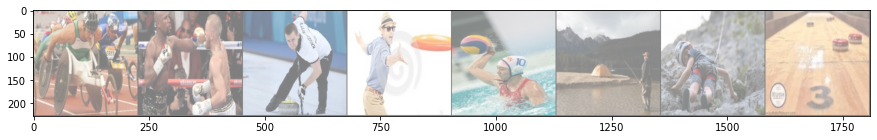

In [6]:
# from dataset import SportDataset
# from utils import matplotlib_imshow
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import pandas as pd


train_transform = transforms.Compose(
    [
    transforms.ToPILImage(mode='RGB'),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor()
    ]
)

val_transform = transforms.transforms.Compose(
    [
    transforms.ToPILImage(mode='RGB'),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
    ]
)

train_ds = SportDataset(csv_file=csv_file, class_file=class_file, root_dir=root_dir, train=True, transform=train_transform)
val_ds = SportDataset(csv_file=csv_file, class_file=class_file, root_dir=root_dir, train=False, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

class_df = pd.read_csv(class_file, usecols=['class_index', 'class'])
class_dict = { row[0]:row[1] for i, row in class_df.iterrows()}
print("class dict: ", class_dict)

dataiter = iter(train_loader)
data = next(dataiter)

plt.rcParams['figure.figsize'] = [15, 5]
# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(data['image'])
matplotlib_imshow(img_grid, one_channel=False)
print(','.join(class_dict[data['labels'][j].item()] for j in range(8)))


### TensorboardX for Logging
logger.py

In [7]:
from tensorboardX import SummaryWriter # have to install pip3 install tensorboardX
import torch
import os
import errno


class Logger:
    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = f'{model_name}_{data_name}'
        self.data_subdir = f'{model_name}/{data_name}'

        self.writer = SummaryWriter(comment=self.comment)


    def loss_log(self, train_loss, val_loss, nth_epoch):
        self.writer.add_scalars(
            'Train vs Val Loss',
            {'Training': train_loss, 'Validation': val_loss},
            nth_epoch
        )
        
    def acc_log(self, train_acc, val_acc, nth_epoch):
        self.writer.add_scalars(
            'Train vs Val Accuracy',
            {'Training': train_acc, 'Validation': val_acc},
            nth_epoch
        )

    def save_models(self, model, nth_epoch):
        out_dir = f'saved/{self.model_name}'
        Logger._make_dir(out_dir)
        torch.save(
            model.state_dict(),
            f'{out_dir}/Ep.{nth_epoch}.pth'
        )

    def close(self):
        self.writer.close()

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

    @staticmethod
    def _step(epoch):
        pass


### Hyperparameters and Loss Function
train.py

In [8]:
import pandas as pd
import time
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision.models.vision_transformer import vit_b_16 as ViT, ViT_B_16_Weights
from torchvision import transforms
from torch.utils.data import DataLoader
# from dataset import SportDataset
# from logger import Logger


lr = 1e-5
epoch_number = 0 # describe the starting epoch if you are continuing training
EPOCHS = 3 # number of epochs to train
model_name = 'vit_b16'
dataset_name = 'sport_dataset'

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [9]:
logger = Logger(model_name, dataset_name)


best_vloss = 100000.
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
timestamp = time.time()

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    since = time.time()
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    running_loss = 0.
    last_loss = 0.
    running_acc = 0.
    train_loop = tqdm(train_loader)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loop):
        # Every data instance is an input + label pair
        inputs, labels = data['image'].to(device), data['labels'].long().to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # print(labels.shape, outputs.shape)
        _, prediction = torch.max(outputs, dim=1)
        corrects = (labels == (prediction)).sum() / len(labels)
        running_acc += corrects

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()

        train_loop.set_postfix(loss=loss.item())

    avg_train_acc = running_acc/len(train_loader)
    avg_train_loss = running_loss/len(train_loader)

    print('Epoch {} loss: {}'.format(epoch_number+1, avg_train_loss))


    # We don't need gradients on to do reporting
    model.train(False)

    vloop = tqdm(val_loader)
    running_vloss = 0.0
    running_vacc = 0.0
    for i, data in enumerate(vloop):
        inputs, labels = data['image'].to(device), data['labels'].long().to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        running_vloss += loss.item()

        _, prediction = torch.max(outputs, dim=1)

        corrects = (prediction == labels).sum() / len(labels)
        running_vacc += corrects

        vloop.set_postfix(loss=loss.item())

    avg_vloss = running_vloss / len(val_loader)
    print('LOSS train {} valid {}'.format(avg_train_loss, avg_vloss))

    avg_vacc = running_vacc / len(val_loader)
    print('Accuracy train {} valid {}'.format(avg_train_acc, avg_vacc))

    # Log the running loss averaged per batch
    # for both training and validation
    logger.loss_log( train_loss=avg_train_loss,
                    val_loss=avg_vloss, nth_epoch=epoch_number+1)

    logger.acc_log( train_acc=avg_train_acc,
                    val_acc=avg_vacc, nth_epoch=epoch_number+1)

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number+1)
        logger.save_models(model=model, nth_epoch=epoch_number+1)

    ep_duration = time.time() - since
    print("Epoch time taken: {:.0f}m {:.0f}s".format(ep_duration // 60, ep_duration % 60))
    epoch_number += 1

total_time = time.time() - timestamp
print("Total time taken: {:.0f}m {:.0f}s".format(total_time // 60, total_time % 60))



EPOCH 1:


100%|██████████| 1697/1697 [06:14<00:00,  4.53it/s, loss=4.25]


Epoch 1 loss: 4.522078672857515


100%|██████████| 63/63 [00:08<00:00,  7.79it/s, loss=4.35]


LOSS train 4.522078672857515 valid 4.389866336943611
Accuracy train 0.03196818009018898 valid 0.0674603208899498
Epoch time taken: 6m 23s
EPOCH 2:


100%|██████████| 1697/1697 [06:15<00:00,  4.52it/s, loss=4.02]


Epoch 2 loss: 4.239855637182259


100%|██████████| 63/63 [00:09<00:00,  6.83it/s, loss=4.28]


LOSS train 4.239855637182259 valid 4.088390634173439
Accuracy train 0.11571891605854034 valid 0.2003968358039856
Epoch time taken: 6m 26s
EPOCH 3:


100%|██████████| 1697/1697 [06:24<00:00,  4.41it/s, loss=3.64]


Epoch 3 loss: 3.903234595752282


100%|██████████| 63/63 [00:06<00:00,  9.34it/s, loss=4.17]


LOSS train 3.903234595752282 valid 3.7400217775314575
Accuracy train 0.2818945348262787 valid 0.3630952537059784
Epoch time taken: 6m 32s
Total time taken: 19m 22s


### Load model and continue training from where I stopped.
I fine-tuned this sport-classification dataset and got 94% maximum validation accuracy at 75th epoch.

The accuracy graph comparison between train and val looks like this:
<img src="img/train_val_accuracy.png" title="Transformer" style="width: 1080;" />  

The loss graph comparison between train and val:  
<img src="img/train_val_loss.png" title="Transformer" style="width: 1080;" />  

The final result of model fine-tuning after 100 epochs and total training is 8.5 hrs on GTX1080Ti 11GB single GPU.
<img src="img/final_training.png" title="Transformer" style="width: 1080px;" />


In [ ]:
print("### Start Loading Model ###")
model.load_state_dict(torch.load('/your/weight/directory/at/Epoch/Ep.30.pth'))
print("### Finished Loading Model ###")

## To do on your own

1. Manage your available resources and continue fine-tune on the same dataset. The pretrained weights at 30th epoch (accuracy = 80%) is giving below link: (Hint: for batch_size = 8 on Puffer will used up 5GB of RAM in one GPU)

    https://drive.google.com/file/d/1P_f5OKNJuk_xpV6efLD5rFOjIyVhMW7I/view?usp=sharinghttps://drive.google.com/file/d/1P_f5OKNJuk_xpV6efLD5rFOjIyVhMW7I/view?usp=sharing

    Feel free to download the file and continue fine-tuning with different settings. Make a challenge to achieve a better performance than my result. There is no bound for the number of epochs to continue. (please don't forget to change the epoch_number=30)

2. With your final fine-tuned weights, try to inference and get the result on images from "test" and "images to predict" directories in sport_dataset. Visualize some random inferenced images with their predictions.

3. Describe your experience on fine-turning and show the graphs from tensorboardX.

